# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Martin Strambach"
student2 = "Claire Capelo"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


### Plotting

In [3]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

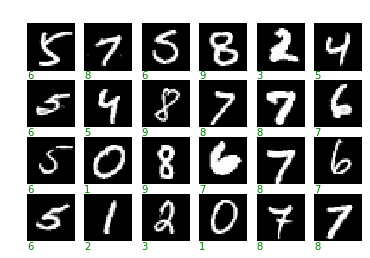

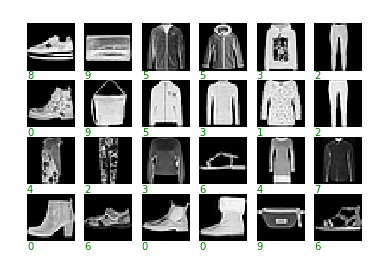

In [4]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

fig1 = plot_some_samples(x_train, y_train)
fig2 = plot_some_samples(x_fashion_train, y_fashion_train)

Answer to question 2: image label

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [5]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [6]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 1s 23us/step - loss: 0.6391 - acc: 0.8320 - val_loss: 0.3952 - val_acc: 0.8947
Epoch 2/20
48000/48000 [==============================] - 1s 17us/step - loss: 0.3943 - acc: 0.8916 - val_loss: 0.3491 - val_acc: 0.9059
Epoch 3/20
48000/48000 [==============================] - 1s 16us/step - loss: 0.3589 - acc: 0.9001 - val_loss: 0.3279 - val_acc: 0.9102
Epoch 4/20
48000/48000 [==============================] - 1s 17us/step - loss: 0.3401 - acc: 0.9051 - val_loss: 0.3160 - val_acc: 0.9115
Epoch 5/20
48000/48000 [==============================] - 1s 16us/step - loss: 0.3282 - acc: 0.9085 - val_loss: 0.3073 - val_acc: 0.9151
Epoch 6/20
48000/48000 [==============================] - 1s 16us/step - loss: 0.3196 - acc: 0.9110 - val_loss: 0.3025 - val_acc: 0.9155
Epoch 7/20
48000/48000 [==============================] - 1s 16us/step - loss: 0.3127 - acc: 0.9127 - val_loss: 0.2979 - val_acc

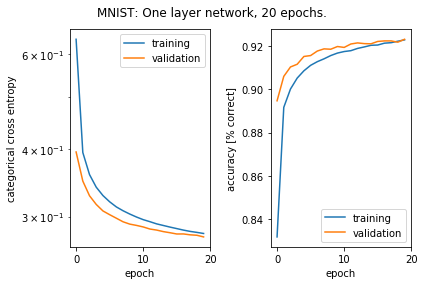

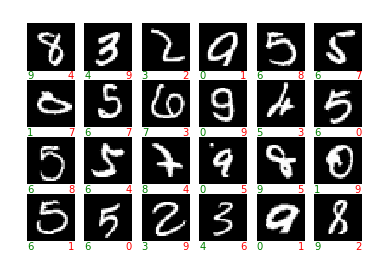

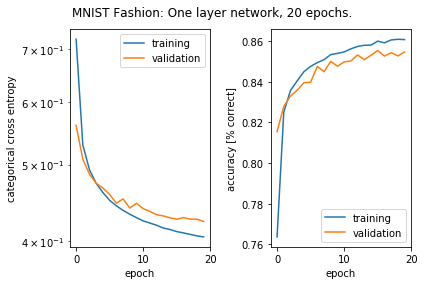

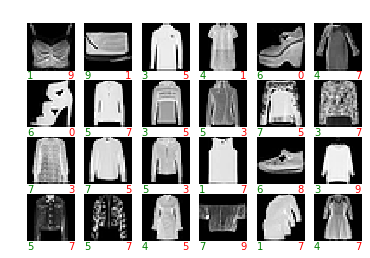

In [7]:
from keras.layers import Activation
num_classes = 10

model = Sequential([
    Dense(num_classes, input_shape=(784,)),
    Activation('softmax'),
])

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2)
plot1 = plot_history(history, "MNIST: One layer network, 20 epochs.")

yhat_test = model.predict(x_test, batch_size=128)
err_indices = np.where(yhat_test.argmax(1) != y_test.argmax(1))[0]
plot2 = plot_some_samples(x_test, y_test, yhat_test, err_indices)

#--------MNIST-Fashion--------#

model = Sequential([
    Dense(num_classes, input_shape=(784,)),
    Activation('softmax'),
])

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_fashion_train, y_fashion_train, epochs=20, batch_size=128, validation_split=0.2)
plot3 = plot_history(history, "MNIST Fashion: One layer network, 20 epochs.")

yhat_fashion_test = model.predict(x_fashion_test, batch_size=128)
err_fashion_indices = np.where(yhat_fashion_test.argmax(1) != y_fashion_test.argmax(1))[0]
plot4 = plot_some_samples(x_fashion_test, y_fashion_test, yhat_fashion_test, err_fashion_indices)

Answer to question 10:

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [8]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    
    finalize_standardplot(fig, ax1, ax2)
    return fig

<Figure size 432x288 with 0 Axes>

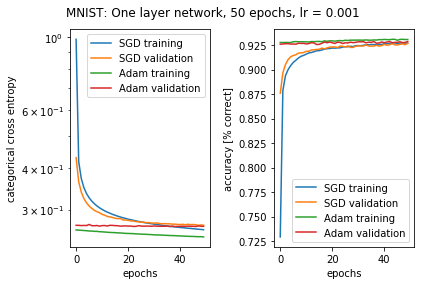

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [9]:
def getModel():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(784,)))
    model.add(Dense(num_classes, activation='softmax'))
    return model

fig = plt.figure()
history_sgd = []
history_adam = []

# Fit the model for 50 epochs with different learning rates
nb_epochs = 50
lr_min = 1e-3
lr_max = 1
# choose the number of learning rates you want to try from lr_min to lr_max
# for the moment it's one, because my PC is slow and I didn't want to make this code run for so long
nb_lr = 1 
lr_list = np.arange(lr_min, lr_max, (lr_max-lr_min)/nb_lr)
for lr in lr_list:
    # First fit the model for SGD
    model_sgd = getModel()
    sgd = SGD(lr=lr, decay=0.0, momentum=0.0, nesterov=False)
    model_sgd.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history_sgd = model.fit(x_train, y_train, epochs=nb_epochs, batch_size=128, validation_split=0.2, verbose=0)
    # Then do the same for Adam (we reload a model such that we optimize the model parameters from the start)
    model_adam = getModel()
    adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model_adam.compile(optimizer=adam,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    history_adam = model.fit(x_train, y_train, epochs=nb_epochs, batch_size=128, validation_split=0.2, verbose=0)
    title = "MNIST: One layer network, {} epochs, lr = {}".format(nb_epochs, lr)
    fig = comparison_plot(history_sgd, history_adam, "SGD", "Adam", title)

plt.show()

# Just to print out the architecture of the NN
getModel().summary()

# Still need to plot a comparison plot with multiple learning rates for both optimizers on the same plot (point 4)
# Points 4 to 6 are still missing

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) 

B) If the learning rate of SGD is very small (eg lr=lr_min=1e-3), we don't observe convergence even on 50 epochs, simply because convergence is way to slow.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**:

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: Loss and accuracy curves can help to detect signs of overfitting: as soon as the test loss increases while the train loss decreases, or as the training accuracy increases while the test accuracy decreases/stays constant, one should suspect overfitting. However, the test error is a bad indicator of accuracy and overfitting. It might happen that the test loss still goes up although the test error goes down (= test accuracy goes up), as it gets even worse on missclassified exemples (which might be outliers?), and decreases less on the samples getting fixed.

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

[<keras.callbacks.History object at 0x7f83441a4048>, <keras.callbacks.History object at 0x7f8343e3b6d8>, <keras.callbacks.History object at 0x7f834b2ab710>, <keras.callbacks.History object at 0x7f8348053780>, <keras.callbacks.History object at 0x7f8348826630>]


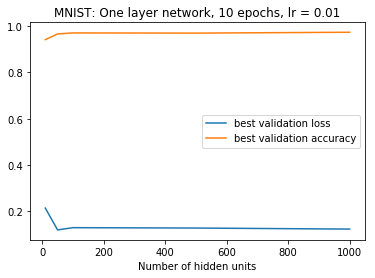

[<keras.callbacks.History object at 0x7f8348025208>, <keras.callbacks.History object at 0x7f834f34dbe0>, <keras.callbacks.History object at 0x7f834b74f9e8>, <keras.callbacks.History object at 0x7f834ef8a4e0>, <keras.callbacks.History object at 0x7f834bc37ba8>]


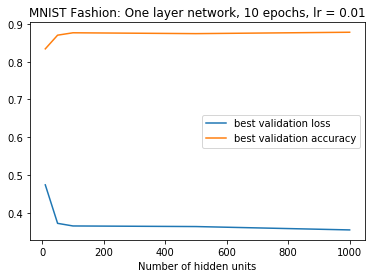

In [20]:
def plot_nb_hidden(history, nb_hidden, title):
    best_val_loss = []
    best_val_acc = []
    for n in range(len(nb_hidden)):
        best_val_loss.append(min(history[n].history['val_loss']))
        best_val_acc.append(max(history[n].history['val_acc']))

    plt.plot(nb_hidden, best_val_loss, label = "best validation loss")
    plt.plot(nb_hidden, best_val_acc, label = "best validation accuracy")
    plt.xlabel('Number of hidden units')
    plt.title(title)
    plt.legend(loc='best')
    plt.show()
    
def getModel(nb_hidden):
    model = Sequential()
    model.add(Dense(nb_hidden, activation='relu', input_shape=(784,)))
    model.add(Dense(num_classes, activation='softmax'))
    return model

lr = 0.01
nb_epochs = 10
nb_hidden = [10, 50, 100, 500, 1000]

for mnist, (x, y) in enumerate([(x_train, y_train), (x_fashion_train, y_fashion_train)]):
    history = []
    for index, nb_unit in enumerate(nb_hidden):
        model = getModel(nb_unit)
        adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(optimizer=adam,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        history.append(model.fit(x, y, epochs=nb_epochs, batch_size=128, validation_split=0.2, verbose=0))

    title = ""
    if mnist == 0:
        title = "MNIST: One layer network, {} epochs, lr = {}".format(nb_epochs, lr)
    if mnist == 1:
        title = "MNIST Fashion: One layer network, {} epochs, lr = {}".format(nb_epochs, lr)
    
    plot_nb_hidden(history, nb_hidden, title)
        


Answer to question 2:

The observed trend is indeed in accordance with the general approximation theorem, since with a sufficient number of hidden neurons, our feedforward network with a single hidden layer can approximate the underlying data distribution (the validation loss goes to zero as the number of hidden units increases). The small deviation that is observed for the MNIST Fashion dataset for nb_epochs=5 (validation loss starts increasing again after the number of hidden units is greater than 500) might be due to the fact that the training becomes slower as the number of neurons increases, and indeed by setting the number of epochs to 10, the validation loss keeps decreasing with the number of hidden units.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [ ]:
def plot_history_custom(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    fig.set_size_inches(12, 8)
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

# We train a naive network of 2 fully connected hidden layers on the Fashion-MNIST dataset
nb_hidden = 50
model_naive = Sequential()
model_naive.add(Dense(nb_hidden, activation='relu', input_shape=(784,)))
model_naive.add(Dense(nb_hidden, activation='relu'))
model_naive.add(Dense(num_classes, activation='softmax'))

nb_epochs = 100
lr = 0.001
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_naive.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_naive = model_naive.fit(x_fashion_train, y_fashion_train, epochs=nb_epochs, batch_size=128, validation_split=0.2, verbose=0)

plot = plot_history_custom(history_naive, "Fashion-MNIST: Two hidden-layers naive network, 100 epochs.")

In [ ]:
# There is a debate about whether BatchNorm should be applied before or after the activation function
# interesting discussion here: 
# https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras
from keras.layers import BatchNormalization
from keras import regularizers

# We train different networks, experimenting with different regularization mechanisms to avoid overfitting
model_regularized = Sequential()
model_regularized.add(Dense(nb_hidden, input_shape=(784,)))
model_regularized.add(BatchNormalization())
model_regularized.add(Activation('tanh'))
model_regularized.add(Dropout(0.5))
model_regularized.add(Dense(nb_hidden)) # first hidden layer
model_regularized.add(BatchNormalization())
model_regularized.add(Activation('tanh'))
model_regularized.add(Dropout(0.5))
model_regularized.add(Dense(nb_hidden)) # second hidden layer
model_regularized.add(BatchNormalization())
model_regularized.add(Activation('tanh'))
model_regularized.add(Dropout(0.5))
model_regularized.add(Dense(num_classes)) # output layer
model_regularized.add(BatchNormalization())
model_regularized.add(Activation('softmax'))

model_regularized.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_regularized = model_regularized.fit(x_fashion_train, y_fashion_train, epochs=nb_epochs, batch_size=128, validation_split=0.2, verbose=0)
plot = plot_history_custom(history_regularized, "Fashion-MNIST: Two hidden-layers regularized network, 100 epochs.")

Answer to question 2 (comments):

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [ ]:
from keras.layers import InputLayer, Activation
# We check what convention keras uses for the ordering of dimensions
# and reshape the training data to include a dimension for channels
from keras import backend as K

img_rows, img_cols = 28, 28 # input image dimensions
x_train_cnn, x_test_cnn, x_fashion_train_cnn, x_fashion_test_cnn = None, None, None, None
if K.image_data_format() == 'channels_first':
    x_train_cnn = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test_cnn = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    x_fashion_train_cnn = x_fashion_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_fashion_test_cnn = x_fashion_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_cnn = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test_cnn = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    x_fashion_train_cnn = x_fashion_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_fashion_test_cnn = x_fashion_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

num_classes = 10
lr = 0.01
nb_epochs = 50
model_cnn = Sequential()
model_cnn.add(InputLayer(input_shape))
model_cnn.add(Conv2D(32, kernel_size=(5, 5)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(3, 3)))
model_cnn.add(Dropout(0.1))
model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(3, 3)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(128))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.15))
model_cnn.add(Dense(num_classes))
model_cnn.add(Activation('softmax'))

adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
model_cnn.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_cnn = model_cnn.fit(x_train_cnn, y_train, epochs=nb_epochs, batch_size=128, validation_split=0.15)

In [ ]:
def plot_history_custom(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    fig.set_size_inches(12, 8)
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig
plot = plot_history_custom(history_cnn, "MNIST: Three hidden-layers convolutional network, relu activations, {} epochs.".format(nb_epochs))


In [ ]:
num_classes = 10
lr = 0.01
nb_epochs = 50
model_cnn = Sequential()
model_cnn.add(InputLayer(input_shape))
model_cnn.add(Conv2D(32, kernel_size=(5, 5)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(3, 3)))
model_cnn.add(Dropout(0.1))
model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(3, 3)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(128))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.15))
model_cnn.add(Dense(num_classes))
model_cnn.add(Activation('softmax'))

adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
model_cnn.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_cnn = model_cnn.fit(x_fashion_train_cnn, y_fashion_train, epochs=nb_epochs, batch_size=128, validation_split=0.15)

In [ ]:
plot = plot_history_custom(history_cnn, "Fashion MNIST: Three hidden-layers convolutional network, relu activations, {} epochs.".format(nb_epochs))

Answer to question 3:

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [ ]:
from keras.layers import InputLayer
from keras import backend as K

img_rows, img_cols = 28, 28 # input image dimensions

x_train_cnn, x_test_cnn, x_fashion_train_cnn, x_fashion_test_cnn = None, None, None, None
if K.image_data_format() == 'channels_first':
    x_train_cnn = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test_cnn = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    x_fashion_train_cnn = x_fashion_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_fashion_test_cnn = x_fashion_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_cnn = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test_cnn = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    x_fashion_train_cnn = x_fashion_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_fashion_test_cnn = x_fashion_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

num_classes = 10
lr = 0.01
nb_epochs = 50
model_cnn = Sequential()
model_cnn.add(InputLayer(input_shape))
model_cnn.add(Conv2D(32, kernel_size=(5, 5)))
model_cnn.add(Activation('sigmoid'))
model_cnn.add(MaxPooling2D(pool_size=(3, 3)))
model_cnn.add(Dropout(0.1))
model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('sigmoid'))
model_cnn.add(MaxPooling2D(pool_size=(3, 3)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(128))
model_cnn.add(Activation('sigmoid'))
model_cnn.add(Dropout(0.15))
model_cnn.add(Dense(num_classes))
model_cnn.add(Activation('softmax'))

adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
model_cnn.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_cnn = model_cnn.fit(x_train_cnn, y_train, epochs=nb_epochs, batch_size=128, validation_split=0.15)

In [ ]:
def plot_history_custom(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    fig.set_size_inches(12, 8)
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig
plot = plot_history_custom(history_cnn, "MNIST: Three hidden-layers convolutional network, sigmoidal activations, {} epochs.".format(nb_epochs))

In [ ]:
# CNN, sigmoidal activation functions
from keras.layers import BatchNormalization

num_classes = 10
lr = 0.01
nb_epochs = 50
model_cnn = Sequential()
model_cnn.add(InputLayer(input_shape))
model_cnn.add(Conv2D(32, kernel_size=(5, 5)))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('sigmoid'))
model_cnn.add(MaxPooling2D(pool_size=(3, 3)))
model_cnn.add(Dropout(0.1))
model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('sigmoid'))
model_cnn.add(MaxPooling2D(pool_size=(3, 3)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(128))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('sigmoid'))
model_cnn.add(Dropout(0.15))
model_cnn.add(Dense(num_classes))
model_cnn.add(BatchNormalization())
model_cnn.add(Activation('softmax'))

adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
model_cnn.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_cnn = model_cnn.fit(x_train_cnn, y_train, epochs=nb_epochs, batch_size=128, validation_split=0.15)

In [ ]:
def plot_history_custom(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    fig.set_size_inches(12, 8)
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig
plot = plot_history_custom(history_cnn, "MNIST: Three hidden-layers convolutional network, sigmoidal activations, {} epochs.".format(nb_epochs))

Answer to question 1:

Answer to question 2: